In [1]:
# Setup the client connection to mongodb server
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017/")
db = client["complete_journey"]

In [2]:
# Data Extraction from Source
import pandas as pd
file_map = {
    "hh_demographic": "hh_demographic.csv",
    "product": "product.csv",
    "campaign_desc": "campaign_desc.csv",
    "campaign_table": "campaign_table.csv",
    "coupon": "coupon.csv",
    "coupon_redempt": "coupon_redempt.csv",
    "transaction_data": "transaction_data.csv",
    "causal_data": "causal_data.csv"
}
data = {name: pd.read_csv(path, low_memory=False) for name, path in file_map.items()}

In [3]:
# Data Cleaning and Transformation
import numpy as np

# -------- helpers --------

# To normalize column names in dataframe
def canon_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (df.columns
        .str.replace('\ufeff','', regex=False)
        .str.strip()
        .str.lower()
    )
    return df

# For pretty-printing
def pp_counts(title, frames_or_lists):
    print(f"\n=== {title} ===")
    for name, obj in frames_or_lists.items():
        if isinstance(obj, pd.DataFrame):
            n = len(obj)
            cols = sorted(obj.columns.tolist())
            print(f"{name:20s} | rows: {n:>9,d} | keys: {', '.join(cols)}")
        elif isinstance(obj, list):
            n = len(obj)
            keys = sorted(list(obj[0].keys())) if n else []
            print(f"{name:20s} | docs: {n:>9,d} | keys: {', '.join(keys)}")
        else:
            print(f"{name:20s} | type {type(obj)} not supported")

# -------- 1) normalize all column names --------
data = {name: canon_cols(df) for name, df in data.items()}

# -------- 2) rename hh_demographic generic fields --------
hh = data["hh_demographic"]
if "classification_1" in hh.columns:
    hh = hh.rename(columns={
        "classification_1": "age_desc",
        "classification_2": "marital_status_code",
        "classification_3": "income_desc",
        "classification_4": "household_size_desc",
        "classification_5": "hh_comp_desc",
    })
data["hh_demographic"] = hh

# -------- 3) pretty-print BEFORE cleanup --------
pp_counts("BEFORE CLEANUP (raw loads)", data)

# -------- 4) filter invalid household references --------
valid_hh = set(data["hh_demographic"]["household_key"].dropna().astype(int))

def filter_by_household(df: pd.DataFrame, col="household_key"):
    if col in df.columns:
        return df[df[col].isin(valid_hh)].copy()
    return df

data["campaign_table"]  = filter_by_household(data["campaign_table"])
data["transaction_data"] = filter_by_household(data["transaction_data"])
data["coupon_redempt"]  = filter_by_household(data["coupon_redempt"])

pp_counts("AFTER filtering invalid household references", data)

# -------- 5) deduplicate ALL tables with explicit PKs --------
# Define primary keys. If a column is missing, we fallback to exact-row dedup.
PRIMARY_KEYS = {
    "hh_demographic":   ["household_key"],
    "product":          ["product_id"],
    "campaign_desc":    ["campaign"],
    "campaign_table":   ["household_key", "campaign"],
    "coupon":           ["campaign", "coupon_upc", "product_id"],
    "coupon_redempt":   ["household_key", "day", "coupon_upc", "campaign"],
    # transaction_data rows are line-items; use a robust composite:
    "transaction_data": ["household_key","basket_id","day","product_id","store_id","week_no","trans_time",
                         "quantity","sales_value","coupon_match_disc","coupon_disc","retail_disc"],
    # causal_data row uniqueness includes display/mailer for a given product-store-week:
    "causal_data":      ["product_id","store_id","week_no","display","mailer"],
}

def safe_dedup(name, df):
    want = PRIMARY_KEYS.get(name, None)
    if want and all(c in df.columns for c in want):
        out = df.drop_duplicates(subset=want).copy()
    else:
        # fallback: exact duplicate rows
        out = df.drop_duplicates().copy()
    return out

for name in data.keys():
    data[name] = safe_dedup(name, data[name])

pp_counts("AFTER de-duplication (primary keys applied)", data)

# -------- 6) restructure into document-oriented shapes (pre-insert) --------
# 6a) Households (as-is)
households_docs = data["hh_demographic"].where(pd.notnull(data["hh_demographic"]), None).to_dict("records")

# 6b) Products (as-is, denormalized columns already present)
products_docs = data["product"].where(pd.notnull(data["product"]), None).to_dict("records")

# 6c) Baskets with embedded items from transaction_data
# group by a stable basket identity
td = data["transaction_data"].copy()
# ensure numeric types are safe
for c in ["household_key","basket_id","day","store_id","week_no","product_id","quantity"]:
    if c in td.columns:
        td[c] = pd.to_numeric(td[c], errors="coerce")

group_cols = ["household_key","basket_id","day","store_id","week_no"]
missing = [c for c in group_cols if c not in td.columns]
if missing:
    raise KeyError(f"transaction_data missing required columns for grouping: {missing}")

baskets_docs = []
for (hh, bid, day, store, wk), grp in td.groupby(group_cols, dropna=False):
    items = grp[["product_id","quantity","sales_value","coupon_disc","coupon_match_disc","retail_disc"]] \
                .where(pd.notnull(grp[["product_id","quantity","sales_value","coupon_disc","coupon_match_disc","retail_disc"]]), None) \
                .to_dict("records")
    baskets_docs.append({
        "household_key": int(hh) if pd.notna(hh) else None,
        "basket_id": int(bid) if pd.notna(bid) else None,
        "day": int(day) if pd.notna(day) else None,
        "store_id": int(store) if pd.notna(store) else None,
        "week_no": int(wk) if pd.notna(wk) else None,
        "items": items
    })

# 6d) Campaigns with embedded target households
ct = data["campaign_table"]
cd = data["campaign_desc"]
target_by_campaign = ct.groupby("campaign")["household_key"].apply(lambda s: sorted(s.dropna().astype(int).unique().tolist())).to_dict()

campaigns_docs = []
for _, row in cd.iterrows():
    c = int(row["campaign"])
    doc = {k: row.get(k) for k in cd.columns}
    # ensure ints and None
    if "campaign" in doc and pd.notna(doc["campaign"]): doc["campaign"] = int(doc["campaign"])
    for k in ["start_day","end_day"]:
        if k in doc and pd.notna(doc[k]): doc[k] = int(doc[k])
    doc["target_households"] = target_by_campaign.get(c, [])
    campaigns_docs.append(doc)

# 6e) Coupons grouped as (campaign, coupon_upc) -> [product_id...]
cp = data["coupon"].copy()
cp["campaign"] = pd.to_numeric(cp["campaign"], errors="coerce")
cp["coupon_upc"] = pd.to_numeric(cp["coupon_upc"], errors="coerce")
cp["product_id"] = pd.to_numeric(cp["product_id"], errors="coerce")

coupons_docs = []
for (c, upc), grp in cp.groupby(["campaign","coupon_upc"], dropna=False):
    if pd.isna(c) or pd.isna(upc): 
        continue
    prod_list = sorted(grp["product_id"].dropna().astype(int).unique().tolist())
    coupons_docs.append({
        "campaign": int(c),
        "coupon_upc": int(upc),
        "product_ids": prod_list
    })

# 6f) Coupon redemptions (as-is)
coupon_redemptions_docs = data["coupon_redempt"].where(pd.notnull(data["coupon_redempt"]), None).to_dict("records")

# 6g) Causal data (as-is, but beware of size; you will chunk inserts later)
causal_data_docs = data["causal_data"].where(pd.notnull(data["causal_data"]), None).to_dict("records")

# -------- 7) pretty-print NEW document sets (pre-insert) --------
new_docs = {
    "households_docs": households_docs,
    "products_docs": products_docs,
    "baskets_docs": baskets_docs,
    "campaigns_docs": campaigns_docs,
    "coupons_docs": coupons_docs,
    "coupon_redemptions_docs": coupon_redemptions_docs,
    "causal_data_docs": causal_data_docs
}
pp_counts("RESTRUCTURED DOCS (pre-insert)", new_docs)

# Verifying that nothing was dropped from transaction_data, since items are now embedded inside basekets
orig_rows = len(data["transaction_data"])
new_items = sum(len(b["items"]) for b in baskets_docs)
print(orig_rows, new_items)  # should be identical

orig_sales = data["transaction_data"]["sales_value"].sum()
new_sales = sum(sum(i["sales_value"] for i in b["items"]) for b in baskets_docs)
print(orig_sales, new_sales)  # should be equal (within float tolerance)


=== BEFORE CLEANUP (raw loads) ===
hh_demographic       | rows:       801 | keys: age_desc, hh_comp_desc, homeowner_desc, household_key, household_size_desc, income_desc, kid_category_desc, marital_status_code
product              | rows:    92,353 | keys: brand, commodity_desc, curr_size_of_product, department, manufacturer, product_id, sub_commodity_desc
campaign_desc        | rows:        30 | keys: campaign, description, end_day, start_day
campaign_table       | rows:     7,208 | keys: campaign, description, household_key
coupon               | rows:   124,548 | keys: campaign, coupon_upc, product_id
coupon_redempt       | rows:     2,318 | keys: campaign, coupon_upc, day, household_key
transaction_data     | rows: 2,595,732 | keys: basket_id, coupon_disc, coupon_match_disc, day, household_key, product_id, quantity, retail_disc, sales_value, store_id, trans_time, week_no
causal_data          | rows: 36,786,524 | keys: display, mailer, product_id, store_id, week_no

=== AFTER filte

In [4]:
# Data Loading into database
from pymongo.errors import BulkWriteError

# ---------- Preconditions (fail fast if a required list is missing) ----------
_required = [
    "households_docs", "products_docs", "baskets_docs",
    "campaigns_docs", "coupons_docs", "coupon_redemptions_docs", "causal_data_docs"
]
_missing = [v for v in _required if v not in globals()]
if _missing:
    raise NameError(f"Missing in scope: {', '.join(_missing)}. "
                    f"All *_docs must be built before running this cell.")

# ---------- Sanitizers (generic, light) ----------
def _to_py_scalar(x):
    if isinstance(x, (np.integer,)): return int(x)
    if isinstance(x, (np.floating,)): return float(x)
    if isinstance(x, (np.bool_,)):   return bool(x)
    if x is None:                    return None
    try:
        if pd.isna(x):               return None
    except Exception:
        pass
    return x

def sanitize_doc(obj, drop_id=True):
    if isinstance(obj, dict):
        out = {}
        for k, v in obj.items():
            if drop_id and k == "_id":
                continue
            out[k] = sanitize_doc(v, drop_id=drop_id)
        return out
    if isinstance(obj, list):
        return [sanitize_doc(v, drop_id=drop_id) for v in obj]
    return _to_py_scalar(obj)

# ---------- Chunked insert with on-the-fly sanitization ----------
def _chunks(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

def insert_sanitized_chunked(coll, docs, chunk_size=100_000, ordered=False, drop_id=True):
    for i, chunk in enumerate(_chunks(docs, chunk_size)):
        sanitized = [sanitize_doc(d, drop_id=drop_id) for d in chunk]
        try:
            coll.insert_many(sanitized, ordered=ordered)
        except BulkWriteError as bwe:
            first = bwe.details.get("writeErrors", [{}])[0]
            idx   = first.get("index")
            msg   = first.get("errmsg")
            raise RuntimeError(
                f"Bulk insert failed in {coll.name} at chunk {i}, doc index {idx}: {msg}"
            ) from bwe

# ---------- Clean collections ----------
for name in ["households","products","baskets","campaigns","coupons","coupon_redemptions","causal_data"]:
    db[name].drop()

# ---------- Inserts (no rebuilds; sanitize while inserting) ----------
insert_sanitized_chunked(db.households,          households_docs,        chunk_size=100_000)
insert_sanitized_chunked(db.products,            products_docs,      chunk_size=100_000)
insert_sanitized_chunked(db.baskets,             baskets_docs,   chunk_size=100_000)
insert_sanitized_chunked(db.campaigns,           campaigns_docs, chunk_size=100_000)
insert_sanitized_chunked(db.coupons,             coupons_docs,   chunk_size=100_000)
insert_sanitized_chunked(db.coupon_redemptions,  coupon_redemptions_docs,       chunk_size=100_000)
insert_sanitized_chunked(db.causal_data,         causal_data_docs,      chunk_size=200_000)

# ---------- Verify counts ----------
print("households:",         db.households.estimated_document_count())
print("products:",           db.products.estimated_document_count())
print("baskets:",            db.baskets.estimated_document_count())
print("campaigns:",          db.campaigns.estimated_document_count())
print("coupons:",            db.coupons.estimated_document_count())
print("coupon_redemptions:", db.coupon_redemptions.estimated_document_count())
print("causal_data:",        db.causal_data.estimated_document_count())

households: 801
products: 92353
baskets: 140339
campaigns: 30
coupons: 1397
coupon_redemptions: 1856
causal_data: 36786524


In [5]:
# =========================
# Exploratory Data Analysis
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

def agg_to_df(coll, pipeline, limit=None):
    """Run aggregation with allowDiskUse and return DataFrame."""
    cur = coll.aggregate(pipeline, allowDiskUse=True)
    recs = list(cur)
    if limit is not None:
        recs = recs[:limit]
    # Promote _id fields into columns if present
    rows = []
    for r in recs:
        row = {}
        for k, v in r.items():
            if k == "_id":
                if isinstance(v, dict):
                    for kk, vv in v.items():
                        row[kk] = vv
                else:
                    row["_id"] = v
            else:
                row[k] = v
        rows.append(row)
    return pd.DataFrame(rows)

def show_df(df, title=None, n=10):
    if title:
        print(f"\n=== {title} ===")
    if df.empty:
        print("(empty)")
    else:
        display(df.head(n))


=== Basket totals & item counts: describe() ===


,count,mean,std,min,25%,50%,75%,90%,95%,max
basket_total,"140,339.00",32.05,38.31,0.00,7.95,19.75,40.21,77.85,110.09,961.49
item_count,"140,339.00",10.17,13.11,1.00,2.00,5.00,13.00,27.00,38.00,168.00


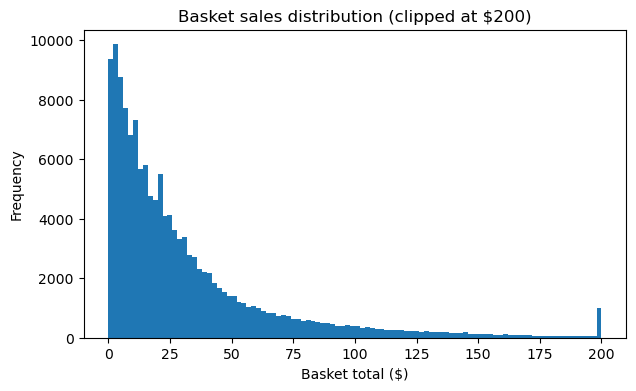

In [6]:
# ---------------------------------------------------------
# 1) Basket-level statistics: totals and line counts
# ---------------------------------------------------------
pipe_basket_stats = [
    {"$project": {
        "basket_total": {"$sum": "$items.sales_value"},
        "item_count": {"$size": "$items"}
    }}
]
df_basket_stats = agg_to_df(db.baskets, pipe_basket_stats)
show_df(df_basket_stats.describe(percentiles=[0.25,0.5,0.75,0.9,0.95]).T, 
        "Basket totals & item counts: describe()")

# Histogram of basket totals (focus on $0–$200 for readability)
fig = plt.figure(figsize=(7,4))
plt.hist(df_basket_stats["basket_total"].clip(upper=200), bins=100)
plt.title("Basket sales distribution (clipped at $200)")
plt.xlabel("Basket total ($)")
plt.ylabel("Frequency")
plt.show()


=== Weekly total sales ===


,week_no,total_sales
0,1,"1,772.61"
1,2,"4,357.27"
2,3,"5,557.75"
3,4,"7,869.38"
4,5,"9,763.53"
5,6,"11,664.44"
6,7,"13,544.50"
7,8,"15,580.91"
8,9,"15,059.69"
9,10,"21,593.81"


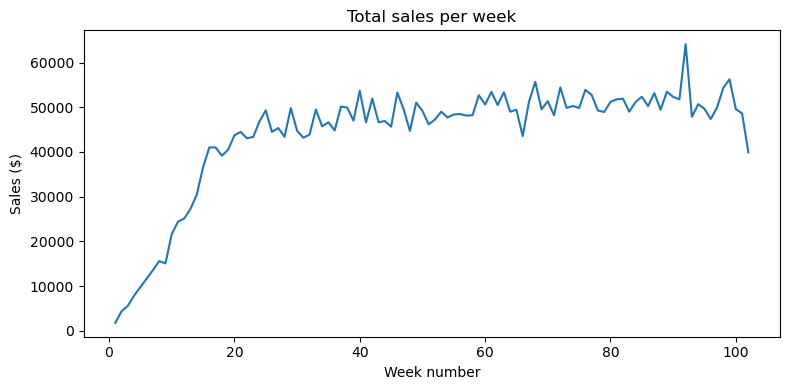

In [7]:
# ---------------------------------------------------------
# 2) Weekly sales trend
# ---------------------------------------------------------
pipe_weekly = [
    {"$unwind": "$items"},
    {"$group": {"_id": "$week_no", "total_sales": {"$sum": "$items.sales_value"}}},
    {"$sort": {"_id": 1}}
]
df_weekly = agg_to_df(db.baskets, pipe_weekly)
df_weekly.rename(columns={"_id":"week_no"}, inplace=True)
show_df(df_weekly, "Weekly total sales")

fig = plt.figure(figsize=(8,4))
plt.plot(df_weekly["week_no"], df_weekly["total_sales"])
plt.title("Total sales per week")
plt.xlabel("Week number")
plt.ylabel("Sales ($)")
plt.tight_layout()
plt.show()


=== Total spend by income band and HH size ===


,Income,HH Size,Total Spend
0,Level1,1,"122,514.19"
1,Level1,2,"128,443.87"
2,Level1,3,"41,254.24"
3,Level1,4,"31,278.94"
4,Level1,5+,"15,645.06"
...,...,...,...
25,Level3,5+,"34,662.34"
26,Level4,1,"221,551.74"
27,Level4,2,"351,397.20"
28,Level4,3,"132,111.82"


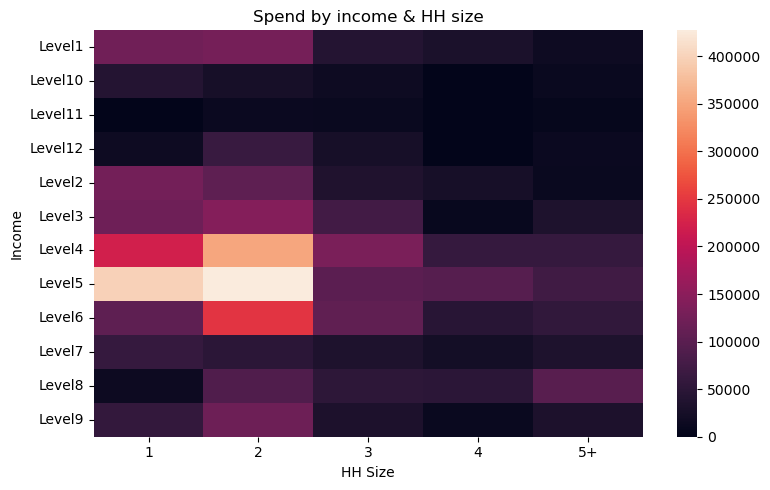

In [8]:
# ---------------------------------------------------------
# 3) Demographic influence on spend (income x HH size)
# ---------------------------------------------------------
pipe_demo = [
    {"$lookup": {
        "from": "households",
        "localField": "household_key",
        "foreignField": "household_key",
        "as": "hh"
    }},
    {"$unwind": "$hh"},
    {"$project": {
        "income": "$hh.income_desc",
        "hh_size": "$hh.household_size_desc",
        "basket_total": {"$sum": "$items.sales_value"}
    }},
    {"$group": {
        "_id": {"income":"$income", "hh_size":"$hh_size"},
        "total_spend": {"$sum": "$basket_total"}
    }},
    {"$sort": {"_id.income":1, "_id.hh_size":1}}
]
df_demo = agg_to_df(db.baskets, pipe_demo)
df_demo.rename(columns={"income":"Income","hh_size":"HH Size","total_spend":"Total Spend"}, inplace=True)
show_df(df_demo, "Total spend by income band and HH size", n=30)

# Heatmap (pivoted)
pt = df_demo.pivot_table(index="Income", columns="HH Size", values="Total Spend", aggfunc="sum").fillna(0)
fig = plt.figure(figsize=(8,5))
sns.heatmap(pt, annot=False, fmt=".0f")
plt.title("Spend by income & HH size")
plt.tight_layout()
plt.show()


Computing Year1 (day ≤ 364) …
rows: 2125
Computing Year2 (day > 364) …
rows: 2121

=== Top 15 growing sub-commodities (pct_change) ===


,yr1_sales,sub_commodity_desc,yr2_sales,pct_change
2242,0.75,WATER GUNS,189.18,"25,124.00"
1585,1.50,PLANTERS,183.00,"12,100.00"
1090,1.46,KABOBS POULTRY,108.78,"7,350.68"
756,6.99,FM-NFL,389.84,"5,477.11"
663,33.40,ELECTRONIC GIFT CARDS REFRESH,"1,643.00","4,819.16"
2004,6.00,SPHE DVDS,195.82,"3,163.67"
1104,1.29,KITES,33.73,"2,514.73"
1264,9.99,MINI 2-5 STEMS,249.75,"2,400.00"
11,1.99,4-20 BOYS TEAM SPORT,46.15,"2,219.10"
1691,3.99,PROMOTIONAL BATH,91.42,"2,191.23"



=== Top 15 declining sub-commodities (pct_change) ===


,yr1_sales,sub_commodity_desc,yr2_sales,pct_change
950,89.32,HAM - BONE-IN WHOLE,0.00,-100.00
1158,26.44,LOIN - WH/HALF,0.00,-100.00
2201,410.97,VARIETY MEAT - CUBE/STW/STRP,0.00,-100.00
2261,48.63,WHOLE/CUTUP,0.00,-100.00
1652,7.99,PREMIUM ORCHIDS POTTED,0.00,-100.00
1656,23.96,PREMIUM SHRUBS,0.00,-100.00
485,5.00,CONTINUITY: TOYS,0.00,-100.00
484,319.26,CONTINUITY: FRAMES,0.00,-100.00
483,1.50,CONTINUITY: FLATWARE/CUTLERY,0.00,-100.00
482,6.00,CONTINUITY: DOMESTICS,0.00,-100.00


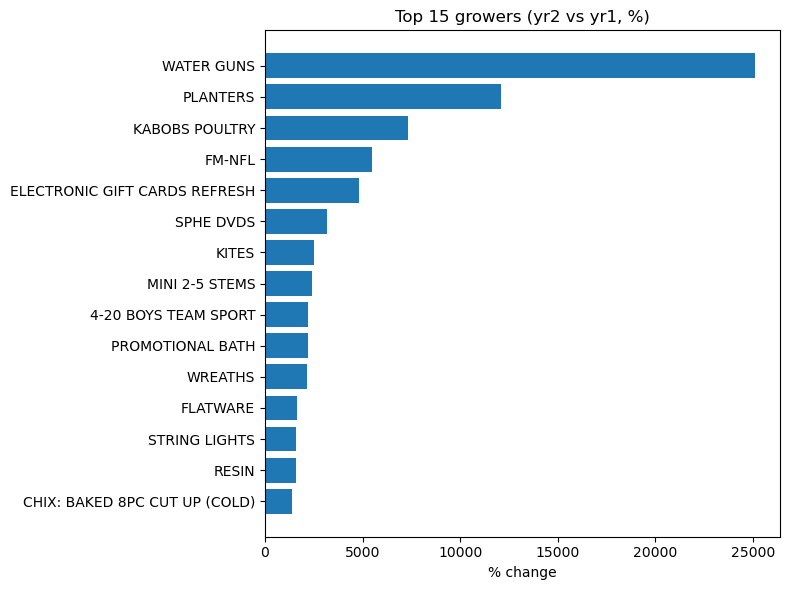

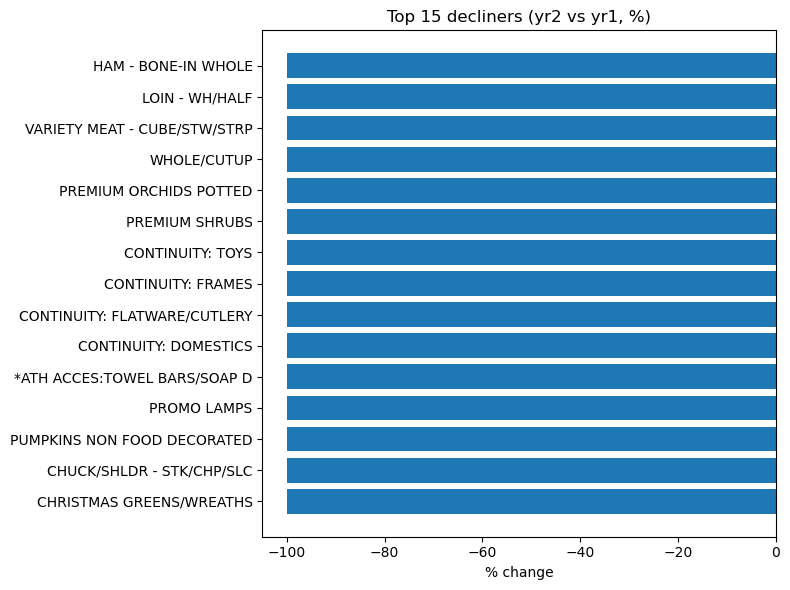

In [9]:
# ---------- 4) Category growth/decline (optimized) ----------
# 1) Ensure supporting indexes (idempotent)
db.products.create_index([("product_id", 1)], unique=True)
db.baskets.create_index([("day", 1)])
db.baskets.create_index([("items.product_id", 1)])  # multikey

# 2) Helper: run agg and convert to DF (reuses your agg_to_df)
def _cat_bucket(day_match):
    """
    Aggregates one bucket (year1 or year2) with early $match on basket.day,
    pruned $project of items, and $lookup that only returns sub_commodity_desc.
    """
    pipe = [
        {"$match": day_match},  # early, uses index on day
        {"$project": {          # shrink docs early
            "day": 1,
            "items": {
                "$map": {
                    "input": "$items",
                    "as": "i",
                    "in": {"product_id": "$$i.product_id", "sales_value": "$$i.sales_value"}
                }
            }
        }},
        {"$unwind": "$items"},
        {"$lookup": {
            "from": "products",
            "let": {"pid": "$items.product_id"},
            "pipeline": [
                {"$match": {"$expr": {"$eq": ["$product_id", "$$pid"]}}},
                {"$project": {"_id": 0, "sub_commodity_desc": 1}}
            ],
            "as": "p"
        }},
        {"$unwind": "$p"},
        {"$group": {
            "_id": "$p.sub_commodity_desc",
            "sales": {"$sum": "$items.sales_value"}
        }},
        {"$project": {"sub_commodity_desc": "$_id", "sales": 1, "_id": 0}}
    ]
    return agg_to_df(db.baskets, pipe)

# 3) Two index-friendly passes instead of one giant conditional-sum group
print("\nComputing Year1 (day ≤ 364) …")
df_y1 = _cat_bucket({"day": {"$lte": 364}})
df_y1.rename(columns={"sales": "yr1_sales"}, inplace=True)
print("rows:", len(df_y1))

print("Computing Year2 (day > 364) …")
df_y2 = _cat_bucket({"day": {"$gt": 364}})
df_y2.rename(columns={"sales": "yr2_sales"}, inplace=True)
print("rows:", len(df_y2))

# 4) Merge and compute % change
df_cat = pd.merge(df_y1, df_y2, on="sub_commodity_desc", how="outer").fillna(0.0)
df_cat["pct_change"] = np.where(df_cat["yr1_sales"] > 0,
                                100 * (df_cat["yr2_sales"] - df_cat["yr1_sales"]) / df_cat["yr1_sales"],
                                np.nan)
df_cat = df_cat.replace([np.inf, -np.inf], np.nan).dropna(subset=["pct_change"])

top_grow = df_cat.sort_values("pct_change", ascending=False).head(15)
top_decl = df_cat.sort_values("pct_change", ascending=True).head(15)

show_df(top_grow, "Top 15 growing sub-commodities (pct_change)")
show_df(top_decl, "Top 15 declining sub-commodities (pct_change)")

# 5) Visuals
fig = plt.figure(figsize=(8,6))
plt.barh(top_grow["sub_commodity_desc"][::-1], top_grow["pct_change"][::-1])
plt.title("Top 15 growers (yr2 vs yr1, %)")
plt.xlabel("% change")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,6))
plt.barh(top_decl["sub_commodity_desc"][::-1], top_decl["pct_change"][::-1])
plt.title("Top 15 decliners (yr2 vs yr1, %)")
plt.xlabel("% change")
plt.tight_layout()
plt.show()


=== Basket totals with vs without coupon (describe by group) ===


,count,mean,std,min,25%,50%,75%,max
flag,,,,,,,,
coupon,"1,228.00",78.77,61.84,0.00,28.73,68.68,115.12,433.01
no_coupon,"139,111.00",31.64,37.78,0.00,7.88,19.56,39.92,961.49


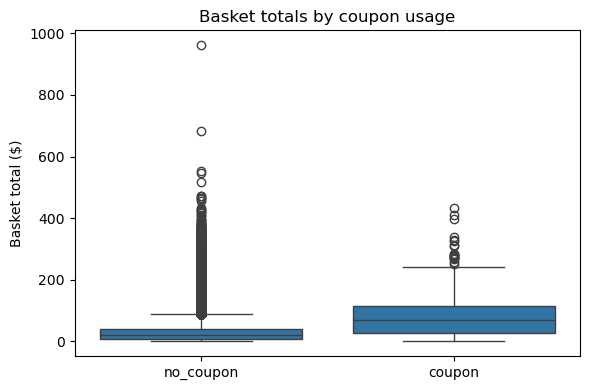

In [10]:
# ---------------------------------------------------------
# 5) Coupon lift: basket totals with vs without coupon
#    Flag a basket as 'coupon' if any redemption matches household_key & day
# ---------------------------------------------------------
pipe_coupon_flag = [
    {"$lookup": {
        "from": "coupon_redemptions",
        "let": {"hh":"$household_key", "dy":"$day"},
        "pipeline": [
            {"$match": {"$expr": {"$and": [
                {"$eq": ["$household_key", "$$hh"]},
                {"$eq": ["$day", "$$dy"]}
            ]}}}
        ],
        "as": "red"
    }},
    {"$project": {
        "basket_total": {"$sum": "$items.sales_value"},
        "flag": {"$cond": [{"$gt": [{"$size": "$red"}, 0]}, "coupon", "no_coupon"]}
    }}
]
df_cf = agg_to_df(db.baskets, pipe_coupon_flag)
show_df(df_cf.groupby("flag")["basket_total"].describe(), "Basket totals with vs without coupon (describe by group)", n=20)

fig = plt.figure(figsize=(6,4))
sns.boxplot(data=df_cf, x="flag", y="basket_total")
plt.title("Basket totals by coupon usage")
plt.xlabel("")
plt.ylabel("Basket total ($)")
plt.tight_layout()
plt.show()

In [11]:
# =========================
# One-time indexing (optional but strongly recommended)
# Safe to re-run; Mongo will no-op if the index already exists.
# =========================
db.baskets.create_index([("day", 1)])
db.baskets.create_index([("household_key", 1), ("day", 1)])
db.baskets.create_index([("store_id", 1), ("week_no", 1)])
db.baskets.create_index([("items.product_id", 1)])  # multikey

db.causal_data.create_index([("product_id", 1), ("store_id", 1), ("week_no", 1)])
db.causal_data.create_index([("display", 1)])

'display_1'


=== Average item sales by display code (optimized) ===


,display,display_label,avg_item_sales
0,0,Not on display,2.86
1,1,Store Front,2.29
2,2,Store Rear,3.05
3,3,Front End Cap,2.58
4,4,Mid-Aisle End Cap,2.91
5,5,Rear End Cap,2.69
6,6,Side-Aisle End Cap,3.24
7,7,In-Aisle,2.50
8,9,Secondary Location,2.88
9,A,In-Shelf,1.94


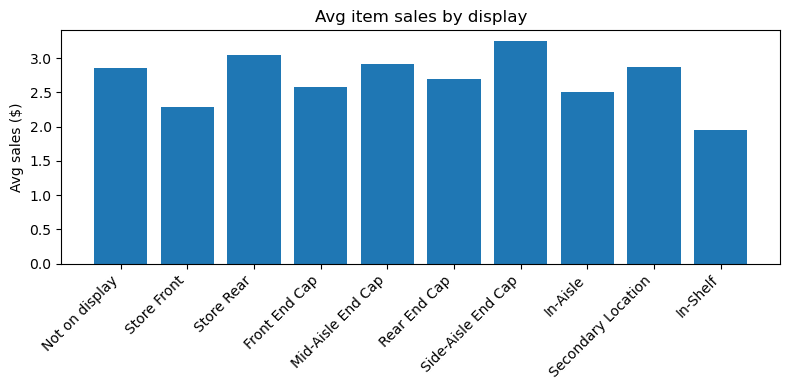

In [12]:
# =========================
# 6) Display effect: avg item sales by display code (optimized)
# Key idea: pre-aggregate items by (product_id, store_id, week_no),
# then join that compact set to causal_data; finally do a weighted average.
# =========================
DISPLAY_LABELS = {
    "0": "Not on display", "1": "Store Front", "2": "Store Rear",
    "3": "Front End Cap", "4": "Mid-Aisle End Cap", "5": "Rear End Cap",
    "6": "Side-Aisle End Cap", "7": "In-Aisle", "9": "Secondary Location",
    "A": "In-Shelf"
}

pipe_disp_fast = [
    {"$unwind": "$items"},
    {"$project": {  # trim payload early
        "pid": "$items.product_id",
        "st": "$store_id",
        "wk": "$week_no",
        "sv": "$items.sales_value",
    }},
    {"$group": {    # collapse millions of items to unique keys
        "_id": {"pid": "$pid", "st": "$st", "wk": "$wk"},
        "sum_sv": {"$sum": "$sv"},
        "cnt": {"$sum": 1},
    }},
    {"$lookup": {   # join once per key (not per item)
        "from": "causal_data",
        "let": {"pid": "$_id.pid", "st": "$_id.st", "wk": "$_id.wk"},
        "pipeline": [
            {"$match": {"$expr": {"$and": [
                {"$eq": ["$product_id", "$$pid"]},
                {"$eq": ["$store_id", "$$st"]},
                {"$eq": ["$week_no", "$$wk"]},
            ]}}},
            {"$project": {"_id": 0, "display": 1}},
        ],
        "as": "c",
    }},
    {"$unwind": "$c"},  # keep only keys that have causal info
    {"$group": {        # aggregate by display and compute weighted sums
        "_id": "$c.display",
        "sum_sv": {"$sum": "$sum_sv"},
        "sum_cnt": {"$sum": "$cnt"},
    }},
    {"$project": {
        "_id": 1,
        "avg_item_sales": {"$divide": ["$sum_sv", "$sum_cnt"]},
    }},
    {"$sort": {"_id": 1}},
]
df_disp = agg_to_df(db.baskets, pipe_disp_fast)
df_disp["display"] = df_disp["_id"].astype(str)
df_disp["display_label"] = df_disp["display"].map(DISPLAY_LABELS).fillna(df_disp["display"])
df_disp = df_disp[["display", "display_label", "avg_item_sales"]]

show_df(df_disp, "Average item sales by display code (optimized)", n=50)

plt.figure(figsize=(8, 4))
plt.bar(df_disp["display_label"], df_disp["avg_item_sales"])
plt.title("Avg item sales by display")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Avg sales ($)")
plt.tight_layout()
plt.show()


=== Campaign 22: total spend in window by group (optimized) ===


,total_spend,hh_count,grp
0,"173,570.71",596,control
1,"79,975.60",180,target


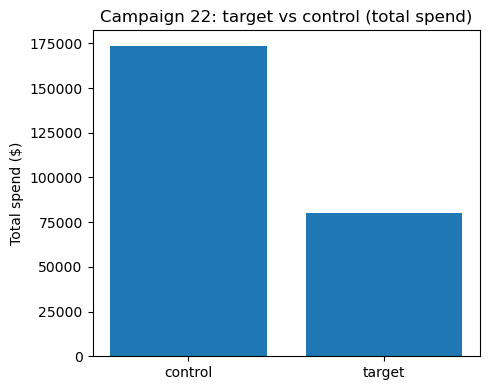

In [13]:
# =========================
# 7) Campaign impact (optimized)
# Key idea: avoid item-level unwind; compute basket_total per doc,
# roll up to household, assign group via $in, then roll up to target/control.
# =========================
campaign_id = 22  # change freely
camp = db.campaigns.find_one({"campaign": campaign_id})

if not camp:
    print(f"\nCampaign {campaign_id} not found.")
else:
    start_day, end_day = camp.get("start_day"), camp.get("end_day")
    targets_list = camp.get("target_households", [])

    pipe_camp_fast = [
        {"$match": {"day": {"$gte": start_day, "$lte": end_day}}},
        {"$project": {
            "household_key": 1,
            "basket_total": {"$sum": "$items.sales_value"},  # sum array per doc
        }},
        {"$group": {  # sum per household
            "_id": "$household_key",
            "hh_spend": {"$sum": "$basket_total"},
        }},
        {"$project": {
            "household_key": "$_id",
            "hh_spend": 1,
            "_id": 0,
        }},
        {"$set": {  # classify group server-side
            "grp": {"$cond": [{"$in": ["$household_key", targets_list]}, "target", "control"]}
        }},
        {"$group": {
            "_id": "$grp",
            "total_spend": {"$sum": "$hh_spend"},
            "hh_count": {"$sum": 1},
        }},
        {"$project": {"grp": "$_id", "total_spend": 1, "hh_count": 1, "_id": 0}},
        {"$sort": {"grp": 1}},
    ]
    df_camp = agg_to_df(db.baskets, pipe_camp_fast)
    show_df(df_camp, f"Campaign {campaign_id}: total spend in window by group (optimized)")

    plt.figure(figsize=(5, 4))
    plt.bar(df_camp["grp"], df_camp["total_spend"])
    plt.title(f"Campaign {campaign_id}: target vs control (total spend)")
    plt.ylabel("Total spend ($)")
    plt.tight_layout()
    plt.show()


=== Campaign 21: normalized per-HH metrics (optimized) ===


,hh,avg_spend,avg_trips,grp
0,734,314.33,9.45,control
1,42,543.50,9.95,target


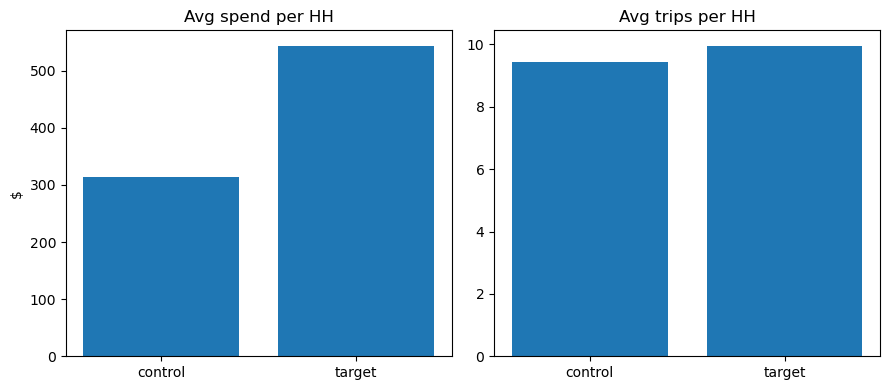

In [14]:
# =========================
# 8) Campaign efficacy normalized (optimized)
# Key idea: compute HH-level spend/trips in Mongo, assign group via $in,
# then aggregate to averages by grp. No Python groupby.
# =========================
campaign_id_norm = 21  # change freely
camp2 = db.campaigns.find_one({"campaign": campaign_id_norm})

if not camp2:
    print(f"\nCampaign {campaign_id_norm} not found.")
else:
    start_day2, end_day2 = camp2.get("start_day"), camp2.get("end_day")
    targets2_list = camp2.get("target_households", [])

    pipe_norm_fast = [
        {"$match": {"day": {"$gte": start_day2, "$lte": end_day2}}},
        {"$project": {
            "household_key": 1,
            "basket_total": {"$sum": "$items.sales_value"},
        }},
        {"$group": {  # HH-level rollup
            "_id": "$household_key",
            "hh_spend": {"$sum": "$basket_total"},
            "hh_trips": {"$sum": 1},
        }},
        {"$project": {
            "household_key": "$_id",
            "hh_spend": 1,
            "hh_trips": 1,
            "_id": 0,
        }},
        {"$set": {
            "grp": {"$cond": [{"$in": ["$household_key", targets2_list]}, "target", "control"]}
        }},
        {"$group": {  # normalized metrics by group
            "_id": "$grp",
            "hh": {"$sum": 1},
            "avg_spend": {"$avg": "$hh_spend"},
            "avg_trips": {"$avg": "$hh_trips"},
        }},
        {"$project": {"grp": "$_id", "hh": 1, "avg_spend": 1, "avg_trips": 1, "_id": 0}},
        {"$sort": {"grp": 1}},
    ]
    df_norm = agg_to_df(db.baskets, pipe_norm_fast)
    show_df(df_norm, f"Campaign {campaign_id_norm}: normalized per-HH metrics (optimized)")

    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.bar(df_norm["grp"], df_norm["avg_spend"])
    plt.title("Avg spend per HH")
    plt.ylabel("$")
    plt.subplot(1, 2, 2)
    plt.bar(df_norm["grp"], df_norm["avg_trips"])
    plt.title("Avg trips per HH")
    plt.tight_layout()
    plt.show()